In [ ]:
! pip install pandas

In [ ]:
! pip install matplotlib

In [ ]:
! pip install seaborn

In [ ]:
! pip install scikit-learn

In [ ]:
! pip install statsmodels

# Exploração de dados

## Carregamento da base de dados e exploração de suas características

In [1]:
import pandas as pd

In [2]:
dataset = pd.read_csv("insurance.csv")
dataset.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


**Conhecendo os dados**

In [3]:
dataset.shape

(1338, 7)

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


_Neste caso, não há dados nulos._

**Analisando dados que são textos**

In [5]:
df_texto = dataset.select_dtypes(include='object')

for coluna in df_texto:
    print(f"Analisando coluna de texto: {coluna}")
    print(set(dataset[coluna]))
    print(dataset[coluna].value_counts())
    print("--------------------------------------------------------------")

Analisando coluna de texto: sex
{'male', 'female'}
sex
male      676
female    662
Name: count, dtype: int64
--------------------------------------------------------------
Analisando coluna de texto: smoker
{'yes', 'no'}
smoker
no     1064
yes     274
Name: count, dtype: int64
--------------------------------------------------------------
Analisando coluna de texto: region
{'southwest', 'northeast', 'northwest', 'southeast'}
region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64
--------------------------------------------------------------


**Analisando os dados do tipo numérico**

In [6]:
dataset.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## Analisando estatísticas descritivas e visualizando distribuições relevantes

A análise estatística descritiva foi feita logo acima, ao analisar pelo describe os dados numéricos.

**Histograma para variáveis numéricas**

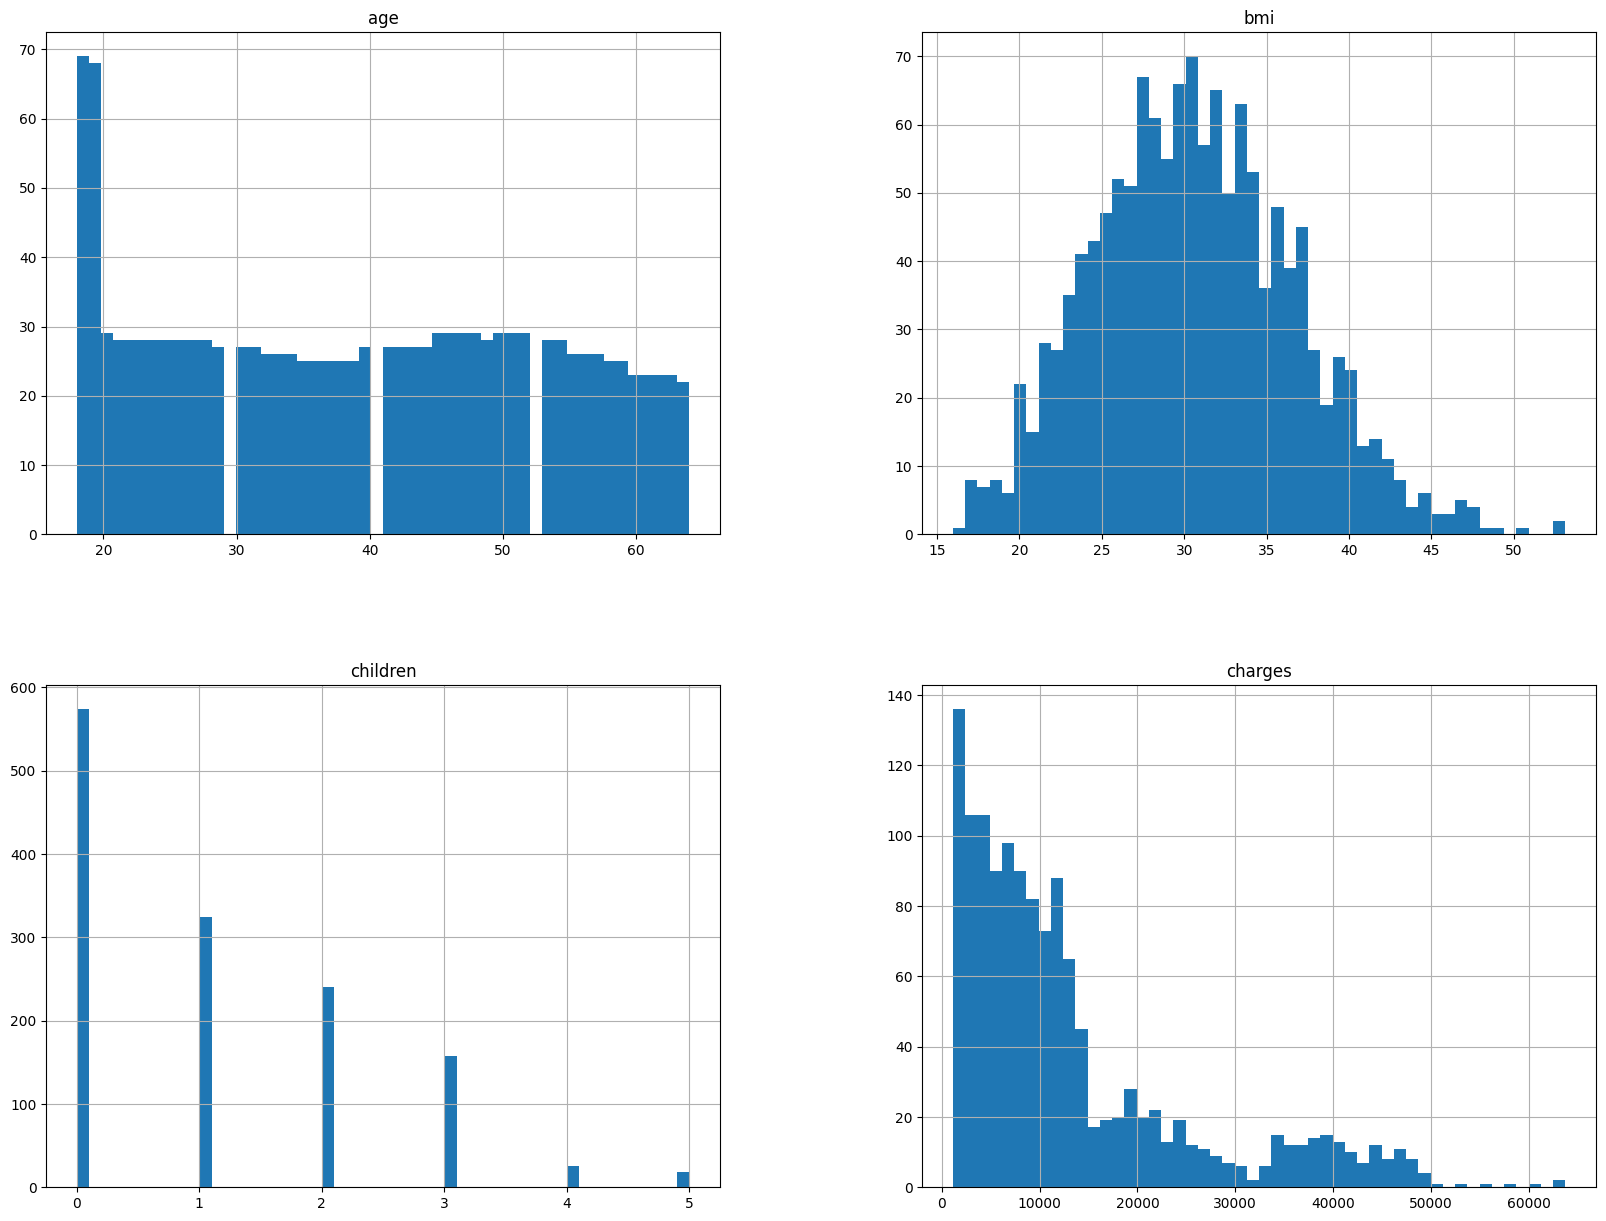

In [7]:
import matplotlib.pyplot as plt

dataset.hist(bins=50, figsize=(20,15))
plt.show()

Observações encontradas:
- a variável "age" parece ter um valor inicial a partir dos 18 anos, onde tem uma grande concentração entre os 18 e 19 anos.
    - pode fazer sentido, já que é nessa idade que se inicia a vida adulta.
- a escala parece meio desproporcional, principalmente ao comparar a "age" e a "bmi" com a variável "children".
    - se for executar em um modelo de ML, pode-se enviezar os dados, ou melhor ocorrer "data lake", de forma que tenda a considerar as duas primeiras variáveis mais importante que esta última. Isso ainda desconsiderando a "charges" por ser a alvo.

**Distribuição das variáveis categóricas**

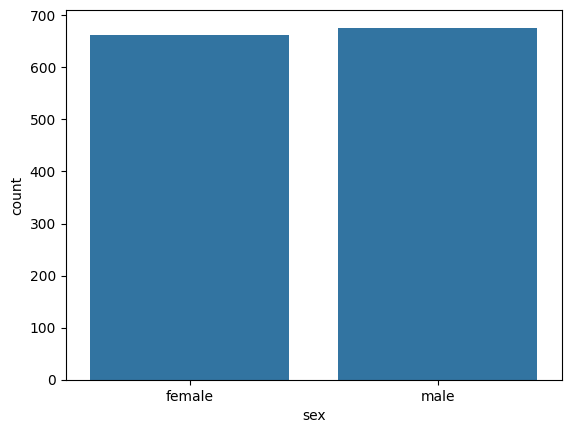

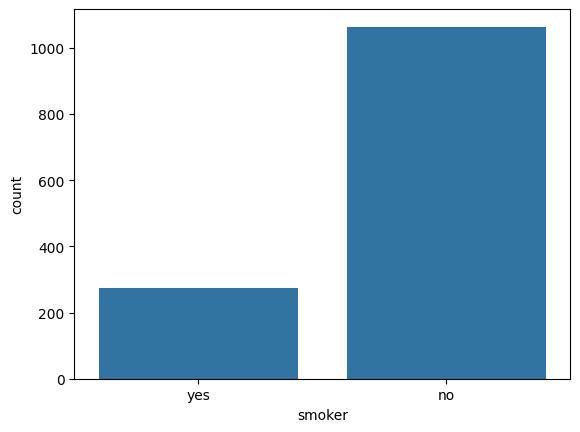

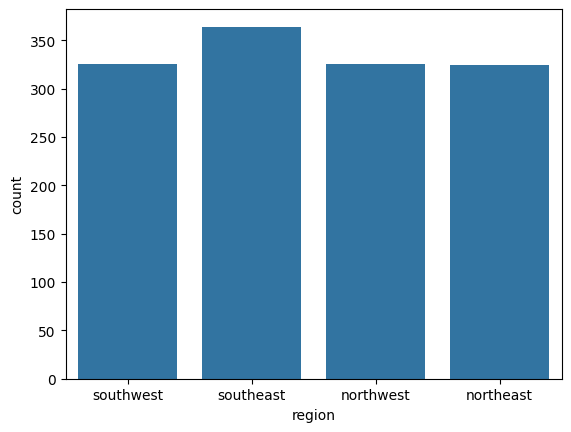

In [8]:
import seaborn as sns

for col in df_texto:
    sns.countplot(x=col, data=dataset)
    plt.show()

_Perbece-se que tanto as features de "sex" e "region" estão de certa forma equilibrada entre suas "categorias", mas em "smoker" temos mais fumantes do que não fumantes. Isso já era possível ser visto quando estavamos explorando os dados não numéricos anteriormente, mas agora de forma visual. Olhando, para o mundo real, pode fazer sentido ter mais fumantes, já que possívelmente eles tem maior problema de saúde e precisam mais de plano, sendo esta uma hipotese._

**Conversão de variáveis categóricas & Análise de correlação**

Para analisar a corelação, é preciso converter os dados para forma numérica, adiantando alguns passos do tratamento de dados.

In [9]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in df_texto:
    dataset[col] = le.fit_transform(dataset[col])

Agora sim podemos executar a correção.

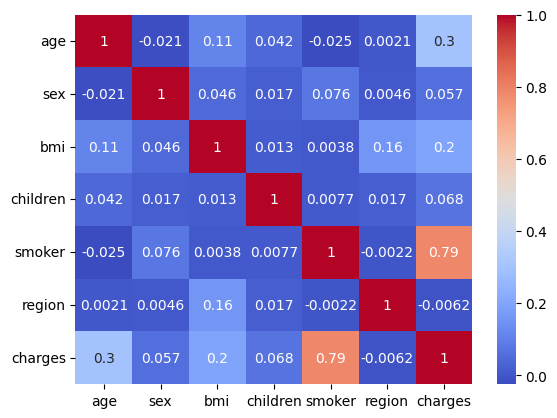

In [10]:
sns.heatmap(dataset.corr(), annot=True, cmap='coolwarm')
plt.show()

_Perbece-se que de fato o "smoker" tem um relação forte com o "charges" que é nosso alvo._

# Pré-processamento de dados

## Limpeza de dados

Como já verificado na etapa de conhecimento dos dados, não há dados nulos/ausentes para serem tratados.

## Conversão de variáveis categóricas em formatos adequados para modelagem

O tratamento das variáveis categóricas, já foram realizados nos passos acima, para poder realizar a visualização da correlação dos dados. Nesse sentido, foi aplicado a estratégia de Label Enconding para que ficasse em formato adequado. 

Foi preferivel o Label Encoding em vez do One Hot Encoding, pois iria aumentar bastante o número de colunas, o que pode atrapalhar a perfomance do modelo.

# Modelagem

## Criação de Modelo Preditivo de Regressão

Vamos seguir com a técnica de Regressão Linear, que parece atender bem para o nosso problema, tendo em vista o alvo sendo "charges", um valor continuo (não categórico).

In [11]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

## Divisão de conjunto de dados em conjuntos de treinamento e teste.

**Separação das features (X) e target (y)**

In [12]:
X = dataset.drop('charges', axis=1)
y = dataset['charges']

**Divisão dos conjuntos**

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinamento e avaliação do modelo

É necessário normalizarmos o X_train e X_test, para ficarem em uma mesma escala e garantir que o modelo entenda com um mesmo "peso".

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Treinamento do modelo

In [15]:
model.fit(X_train_scaled, y_train)

LinearRegression()

# Validação estátistica

**Previsão**

In [16]:
y_pred = model.predict(X_test_scaled)

**Métricas de avaliação**

In [17]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

Mean Squared Error: 33635210.431178436
R-squared: 0.7833463107364537


## p-values e intervalos de confiança

Para analisar esses tipos de métricas, vamos realizar a modelagem com statsmodels

In [18]:
import statsmodels.api as sm

# Manter a coluna constante após escalonamento
X_train_scaled_sm = sm.add_constant(X_train_scaled, has_constant='add')
X_test_scaled_sm = sm.add_constant(X_test_scaled, has_constant='add')

# Modelagem com statsmodels
model_sm = sm.OLS(y_train, X_train_scaled_sm).fit()

# Resumo do modelo
print(model_sm.summary())

# Previsão e avaliação do modelo
y_pred_sm = model_sm.predict(X_test_scaled_sm)

# Métricas de avaliação
mse_sm = mean_squared_error(y_test, y_pred_sm)
r2_sm = r2_score(y_test, y_pred_sm)

print(f'Mean Squared Error (statsmodels): {mse_sm}')
print(f'R-squared (statsmodels): {r2_sm}')


                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.740
Method:                 Least Squares   F-statistic:                     508.7
Date:                Sun, 26 May 2024   Prob (F-statistic):          2.71e-308
Time:                        14:28:02   Log-Likelihood:                -10845.
No. Observations:                1070   AIC:                         2.170e+04
Df Residuals:                    1063   BIC:                         2.174e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.335e+04    187.273     71.265      0.0

# Itens de avaliação

## Gráfico de previsões vs. valores reais

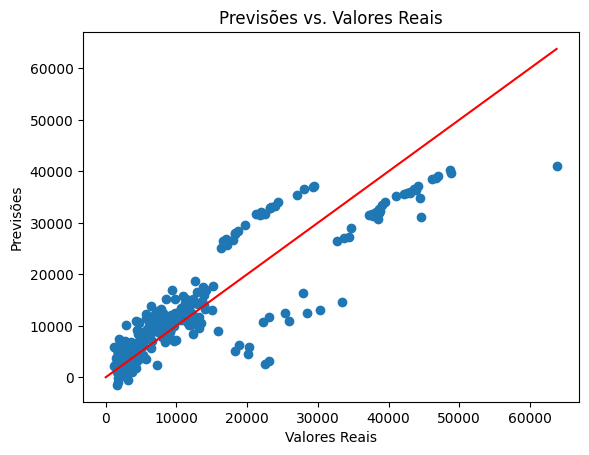

In [19]:
plt.scatter(y_test, y_pred)
plt.xlabel('Valores Reais')
plt.ylabel('Previsões')
plt.title('Previsões vs. Valores Reais')
plt.plot([0, max(y_test)], [0, max(y_test)], color='red')
plt.show()

**Interpretação do Gráfico:**
1. Aproximação Geral:

Há uma tendência geral de os pontos seguirem a linha vermelha, o que sugere que o modelo está capturando parte da relação entre as variáveis de entrada e os custos médicos.

2. Dispersão dos Pontos:

No entanto, há uma dispersão significativa dos pontos, especialmente para valores mais altos de custos reais. Isso indica que o modelo está tendo dificuldades em prever valores altos de custos médicos com precisão.

3. Valores Subestimados:

A maioria dos pontos para valores reais mais altos (acima de 20.000) está abaixo da linha vermelha. Isso indica que o modelo tende a subestimar os custos médicos mais altos.

4. Concentração de Pontos:

Há uma concentração de pontos em torno de valores reais mais baixos (menos de 10.000), onde o modelo parece performar melhor. No entanto, mesmo nessa região, há uma dispersão considerável.

## Relatório

O próprio notebook, servirá como relatório do Tech Challenge. 

Segue ainda, um resuminho das etapas aqui realizadas.

In [20]:
report = f"""
Relatório de Análise e Modelagem de Previsão de Custos Médicos

Exploração de Dados:
- Visualização das primeiras linhas do dataframe
{dataset.head()}

- Análise estatística descritiva
{dataset.describe()}

Pré-processamento de Dados:
- Tratamento de valores ausentes: Não foi necessário
- Conversão de variáveis categóricas: Utilizou-se Label Encoding para as colunas {df_texto}
- Normalização de todas as variáveis: Utilizou-se StandardScaler após a divisão dos dados

Modelagem:
- Técnica utilizada: Regressão Linear
- Divisão do conjunto de dados: 80% treinamento e 20% teste

Treinamento e Avaliação do Modelo:
- Mean Squared Error: {mse}
- R-squared: {r2}

Gráficos e Visualizações:
- Distribuições das variáveis
- Análise de correlação
- Gráfico de Previsões vs. Valores Reais
"""

print(report)


Relatório de Análise e Modelagem de Previsão de Custos Médicos

Exploração de Dados:
- Visualização das primeiras linhas do dataframe
   age  sex     bmi  children  smoker  region      charges
0   19    0  27.900         0       1       3  16884.92400
1   18    1  33.770         1       0       2   1725.55230
2   28    1  33.000         3       0       2   4449.46200
3   33    1  22.705         0       0       1  21984.47061
4   32    1  28.880         0       0       1   3866.85520

- Análise estatística descritiva
               age          sex          bmi     children       smoker  \
count  1338.000000  1338.000000  1338.000000  1338.000000  1338.000000   
mean     39.207025     0.505232    30.663397     1.094918     0.204783   
std      14.049960     0.500160     6.098187     1.205493     0.403694   
min      18.000000     0.000000    15.960000     0.000000     0.000000   
25%      27.000000     0.000000    26.296250     0.000000     0.000000   
50%      39.000000     1.000000  